---
title: 'Chapter 5: Image segmentation'
jupyter: python3
format:
  html:
    embed-resources: true
  pdf:
    documentclass: article
    toc: true
    fontsize: 12pt
    geometry:
      - top=1in
      - bottom=1in
      - left=1in
      - right=1in
      - heightrounded
---


# Introduction
After we have a binary mask with all the desired objects in the foreground, the
next step is to label each individual object with a unique ID. A segmentation
algorithm typically takes as an input image (can be binary or grayscale, but we
will focus on binary) and partitions it into distinct objects each with a
different id.  A segmentation algorithm does not modify the input image, but
generates a separate image with the object IDs. This image is called the label
image, and is of the same size as the input image. Each pixels in the image is
an number uniquely representing an object in the input image. This labels image
can then the used together with the input image to extract the desired
information about each object. 



# Connected components segmentation

Connected components segmentation labels each of the connected (touching)
foreground pixels as an object, i.e an object is entirely surrounded by
background pixels. This segmentation is most useful then the object or sparse
and not touching one another. If there are touching objects they will not be
separated and get labeled with the same ID. 


Number of segmented objects = 117


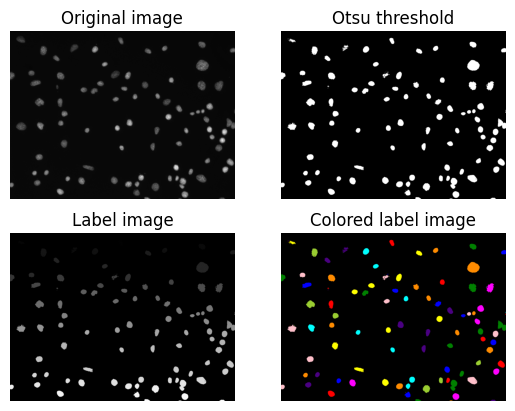

In [88]:
# Load the required libraries
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt

# Load the cell images
img = ski.io.imread("data/F01_202w2.TIF")

# Get the image histogram
hist, hist_centers = ski.exposure.histogram(img)

# Get the Otsu threshold
otsu_thresh = ski.filters.threshold_otsu(img)

# Binary threshold the image
img_otsu = img > otsu_thresh

# Get the connected components segmentation
label_img = ski.morphology.label(img_otsu)
# The number of segmented objects is the maximum value of the 
# label image
print('Number of segmented objects = ' + str(label_img.max()))

# Color the label image for visualization
label_img_overlay = ski.color.label2rgb(label_img)

# Plot the images
fig, ax =  plt.subplots(2, 2)
ax[0, 0].imshow(img, cmap = 'gray')
ax[0, 0].set_title('Original image')
ax[0, 1].imshow(img_otsu, cmap = 'gray')
ax[0, 1].set_title('Otsu threshold')
ax[1, 0].imshow(label_img, cmap = 'gray')
ax[1, 0].set_title('Label image')
ax[1, 1].imshow(label_img_overlay)
ax[1, 1].set_title('Colored label image')
for a in ax.flatten():
    a.set_axis_off()

The label image typically contains a 0 for the background as well, i.e the
pixels that do not correspond to any object. As can the seen in the grayscale
image, each objects starting from the top right get labeled with a distinct
integer (thus represented as a shade of gray). The labels images are often
overlaid with the original image and/or pseudo-colored for better visualization
of the segmented objects. 



# Watershed segmentation

Watershed segmentation is a way to segment objects when they are touching one
another.  Watershed segments a grayscale image by treating the intensity of the
image as the height of the dam. Think of the bright regions of the image as
tall structures and dimmer regions as shorter structures. Watershed
segmentation starts flooding the image from the lowest regions (or regions
specified by the user), and when a dam overflows into an another one, a
segmentation boundary is created. 

Number of segmented objects = 117


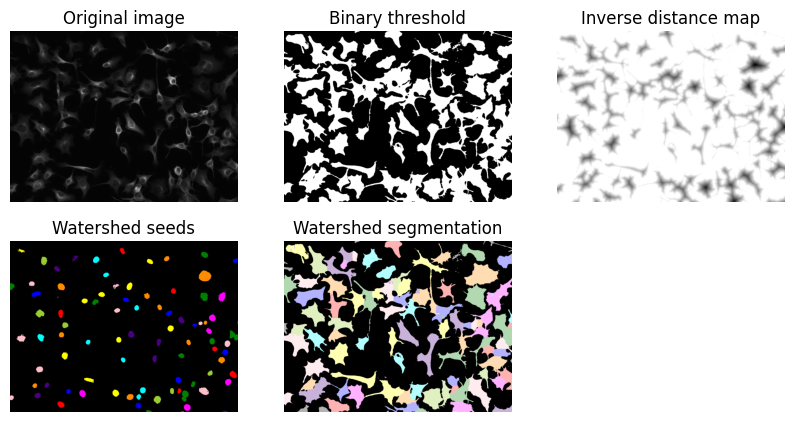

In [89]:
from scipy import ndimage as ndi

# Load the cell images
cyto = ski.io.imread("data/F01_202w1.TIF")
nuc = ski.io.imread("data/F01_202w2.TIF")

# Triange threshold the cytoplasm
cyto_bin = cyto > ski.filters.threshold_triangle(cyto)

# Get the distance trasform of the nucleus
cyto_dist = ndi.distance_transform_edt(cyto_bin)
# Negate the distance so that the cell boundars have
# the largest value, and the innermost regions of a
# cell have the least value
cyto_dist = - cyto_dist

# Otsu threshold the nucleus
nuc_bin = nuc > ski.filters.threshold_otsu(nuc)
# Get the connected components of the nucleus
# These will be used as seeds for the watershed segmentation
nuc_label = ski.morphology.label(nuc_bin)

# Watershed segmentation
label_img = ski.segmentation.watershed(cyto_dist, 
                markers = nuc_label, mask = cyto_bin)
print('Number of segmented objects = ' + str(label_img.max()))

# Color the label image for visualization
label_img_overlay = ski.color.label2rgb(label_img, cyto_bin)

# Plot the images
fig, ax =  plt.subplots(2, 3, figsize = (10, 5))
ax[0, 0].imshow(cyto, cmap = 'gray')
ax[0, 0].set_title('Original image')
ax[0, 1].imshow(cyto_bin, cmap = 'gray')
ax[0, 1].set_title('Binary threshold')
ax[0, 2].imshow(cyto_dist, cmap = 'gray')
ax[0, 2].set_title('Inverse distance map')
ax[1, 0].imshow(ski.color.label2rgb(nuc_label), cmap = 'gray')
ax[1, 0].set_title('Watershed seeds')
ax[1, 1].imshow(label_img_overlay, cmap = 'gray')
ax[1, 1].set_title('Watershed segmentation')
for a in ax.flatten():
    a.set_axis_off()